In [63]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from pandas.api.types import CategoricalDtype
from plotnine import ggplot, aes, geom_line, labs, theme, facet_wrap, scale_color_manual
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)

In [64]:
df = pd.read_csv('../data/ground_station.csv')
df = df.drop("Created_at",axis=1)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df['Timestamp'] = df['Timestamp'].dt.tz_localize('UTC').dt.tz_convert('Etc/GMT-12')
df = df.sort_values('Timestamp').reset_index(drop=True)
df = df.set_index('Timestamp')
df = df.drop(columns=['Longitude', 'Latitude'])
df.index = df.index.tz_localize(None)

In [65]:
df.describe()

,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature
count,115673.000000,115673.000000,115673.000000,115673.000000,115673.00000,115673.000000,109974.000000
mean,10.701321,68.941043,0.005780,1.570272,179.17259,7690.919999,10.579231
std,11.029890,23.906514,0.533921,1.537215,115.98962,1917.643090,11.479107
min,-20.640000,6.000000,0.000000,0.000000,0.00000,-1.000000,-11.560000
25%,0.650000,50.600000,0.000000,0.400000,122.00000,7232.000000,0.000000
50%,10.930000,71.500000,0.000000,1.350000,168.00000,8128.000000,9.810000
75%,18.090000,91.100000,0.000000,2.240000,311.00000,8816.000000,16.930000
max,43.430000,100.000000,119.862600,37.390000,359.00000,10288.000000,54.680000


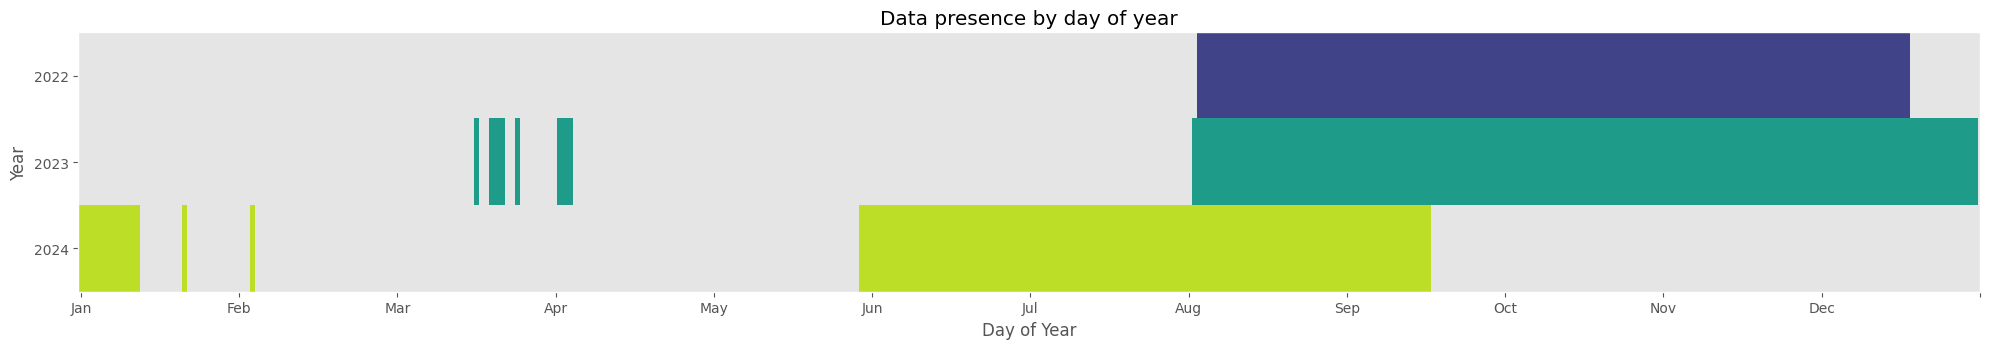

In [66]:
presence = pd.Series(1, index=df.index)
presence = presence.resample('D').max()

# Create DataFrame with date info
presence_df = presence.to_frame('present')
presence_df['year'] = presence_df.index.year
presence_df['day_of_year'] = presence_df.index.dayofyear

# Create presence matrix by year x day
matrix = presence_df.pivot(index='year', columns='day_of_year', values='present')

# Create colormap with one color per year
years = matrix.index
n_years = len(years)
colors = plt.cm.viridis(np.linspace(0.2, 0.9, n_years))
cmap = mcolors.ListedColormap(colors)
data_colored = np.array([
    row * i if not np.all(np.isnan(row)) else np.nan
    for i, row in enumerate(matrix.values, start=1)
])

# Plotar
plt.figure(figsize=(20, n_years * 1.2))
plt.imshow(data_colored, aspect='auto', cmap=cmap, interpolation='none')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.title('Data presence by day of year')
plt.xticks(np.linspace(0, 365, 13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',''])
plt.yticks(ticks=np.arange(len(years)), labels=years)
plt.grid(False)
plt.tight_layout()
plt.show()

In [67]:
# Considera apenas linhas sem NaN
df_valid = df[df.notna().all(axis=1)].copy()
# Ordena o índice
df_valid = df_valid.sort_index()

# Calcula a diferença entre índices consecutivos em horas
diffs = df_valid.index.to_series().diff().dt.total_seconds().div(3600).fillna(1)

# Inicia um grupo novo sempre que o gap for maior que 2 horas
group = (diffs > 4).cumsum()

# Conta o tamanho de cada grupo
streak_sizes = group.value_counts().sort_index()

# Encontra o maior grupo
max_group = streak_sizes.idxmax()
max_streak = streak_sizes.max()

# Índices do maior grupo
mask = group == max_group
start = df_valid.index[mask][0]
end = df_valid.index[mask][-1]
df = df_valid.loc[mask].copy()
print(f'Maior sequência permitindo furos de até 4 horas: {max_streak} registros')
print(f'De {start} até {end}')

Maior sequência permitindo furos de até 4 horas: 44201 registros
De 2023-08-03 02:36:59 até 2024-01-12 11:27:04


In [ ]:
df = df.resample('30min').mean()

In [69]:
len(df)

7794

In [70]:
df.head()

,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature
Timestamp,,,,,,,
2023-08-03 02:30:00,21.414000,38.500000,1.899920,0.144000,78.200000,6092.800000,21.384000
2023-08-03 03:00:00,22.531667,38.416667,3.166533,15.761667,244.833333,5770.666667,28.695000
2023-08-03 03:30:00,25.221667,28.916667,53.225683,12.341667,163.000000,5789.333333,31.653333
2023-08-03 04:00:00,23.860000,25.250000,7.683483,1.275000,150.166667,6202.666667,24.226667
2023-08-03 04:30:00,22.570000,26.916667,0.000000,1.521667,172.500000,6266.666667,19.496667


In [71]:
decomps = {}
residuals = pd.DataFrame(index=df.index)
for col in df.columns:
    if col == 'Timestamp':
        continue
    stl_res = STL(df[col], period=24, robust=True).fit()
    decomps[col] = stl_res
    residuals[col] = stl_res.resid

In [72]:
iso = IsolationForest(contamination='auto', random_state=42)
iso.fit(residuals)

IsolationForest(random_state=42)

In [73]:
flags = iso.predict(residuals)
is_multivariate_anomaly = pd.Series(flags == -1, index=residuals.index)
df['is_multivariate_anomaly'] = is_multivariate_anomaly
df.head()

,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature,is_multivariate_anomaly
Timestamp,,,,,,,,
2023-08-03 02:30:00,21.414000,38.500000,1.899920,0.144000,78.200000,6092.800000,21.384000,False
2023-08-03 03:00:00,22.531667,38.416667,3.166533,15.761667,244.833333,5770.666667,28.695000,True
2023-08-03 03:30:00,25.221667,28.916667,53.225683,12.341667,163.000000,5789.333333,31.653333,True
2023-08-03 04:00:00,23.860000,25.250000,7.683483,1.275000,150.166667,6202.666667,24.226667,False
2023-08-03 04:30:00,22.570000,26.916667,0.000000,1.521667,172.500000,6266.666667,19.496667,False


In [74]:
print('Found {} outliers'.format(is_multivariate_anomaly.sum()))

Found 416 outliers


In [75]:
df_clean = df.copy()
for col, stl_res in decomps.items():
    cleaned_series = df[col].copy()
    cleaned_series[is_multivariate_anomaly] = (stl_res.trend + stl_res.seasonal)[is_multivariate_anomaly]
    df_clean[col] = cleaned_series
df_clean.drop(columns=['is_multivariate_anomaly'], inplace=True)
df.drop(columns=['is_multivariate_anomaly'], inplace=True)
df_clean.head()

,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature
Timestamp,,,,,,,
2023-08-03 02:30:00,21.414000,38.500000,1.899920,0.144000,78.200000,6092.800000,21.384000
2023-08-03 03:00:00,22.657549,37.803226,3.166533,5.308020,276.485994,6485.685640,21.052415
2023-08-03 03:30:00,24.999570,29.407654,53.225683,7.862876,165.764942,6471.860479,31.784270
2023-08-03 04:00:00,23.860000,25.250000,7.683483,1.275000,150.166667,6202.666667,24.226667
2023-08-03 04:30:00,22.570000,26.916667,0.000000,1.521667,172.500000,6266.666667,19.496667


In [ ]:
print('--- Original ---')
print(df.describe())
print('--- Cleaned ---')
print(df_clean.describe())

--- Original ---
       Temperature     Humidity  Precipitation  Wind_Speed_kmh  \
count  7794.000000  7794.000000    7794.000000     7794.000000   
mean      6.585865    78.922014       0.009962        1.084365   
std       9.190638    21.777696       0.610856        1.015352   
min     -20.356667    12.700000       0.000000        0.000000   
25%      -0.947083    63.037500       0.000000        0.193333   
50%       4.375833    87.116667       0.000000        0.866667   
75%      12.946667    97.662500       0.000000        1.828333   
max      40.090000   100.000000      53.225683       15.761667   

       Wind_Direction  Soil_Moisture  Soil_Temperature  
count     7794.000000    7794.000000       7794.000000  
mean       190.765518    8450.541374          7.150491  
std         94.239235     791.382025          9.166315  
min          0.000000    5770.666667         -6.411667  
25%        141.666667    8008.666667         -0.130000  
50%        180.000000    8834.666667          

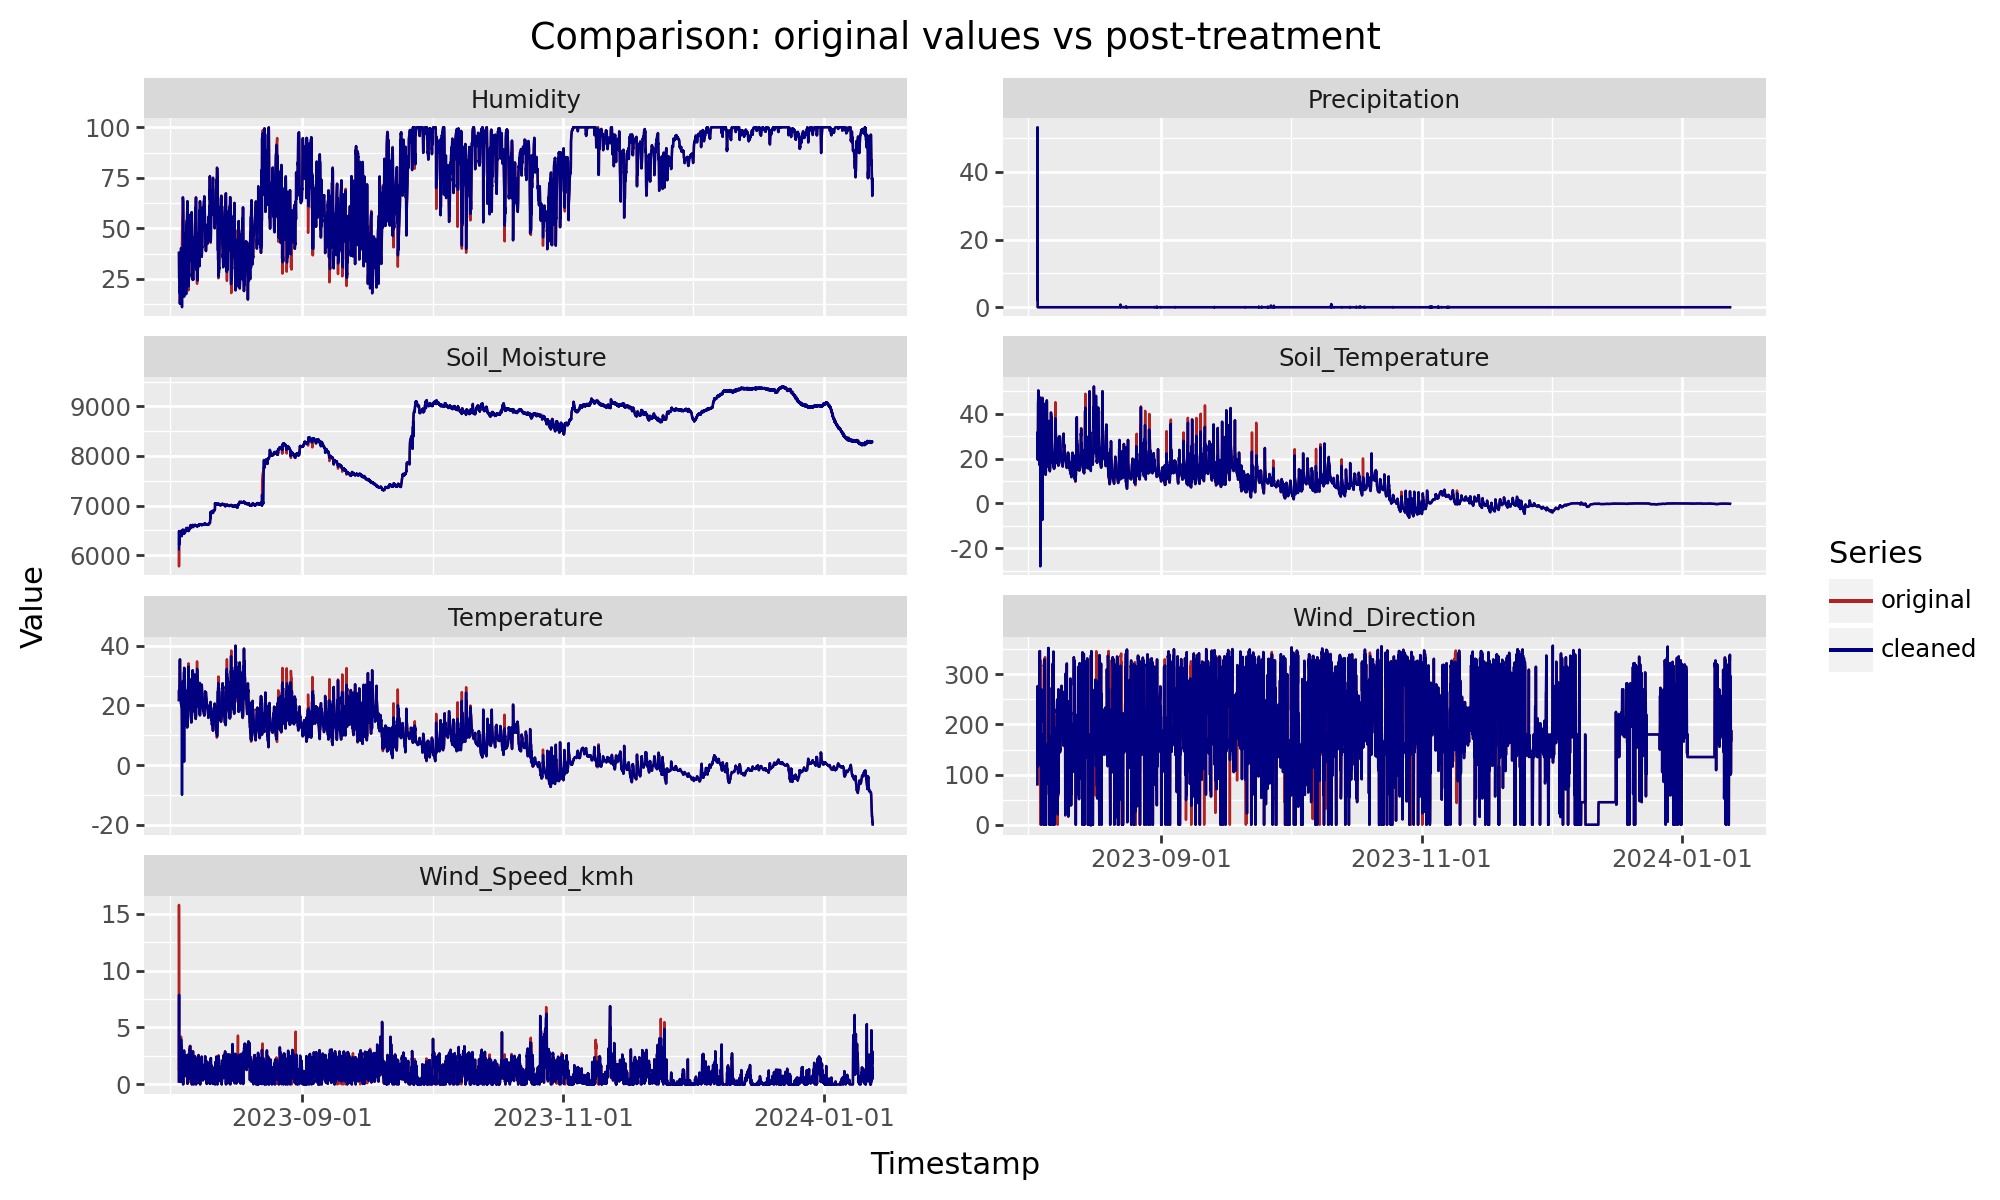

In [77]:
orig_long = (
    df
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
    .assign(type='original')
)

clean_long = (
    df_clean
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
    .assign(type='cleaned')
)

combined = pd.concat([orig_long, clean_long], ignore_index=True)
type_order = CategoricalDtype(['original', 'cleaned'], ordered=True)
combined['type'] = combined['type'].astype(type_order)

plot = (
    ggplot(combined, aes('Timestamp', 'value', color='type'))
    + geom_line()
    + facet_wrap('~variable', scales='free_y', ncol=2)
    + scale_color_manual(values=['firebrick', 'navy'])
    + labs(
        title='Comparison: original values vs post-treatment',
        x='Timestamp',
        y='Value',
        color='Series'
    )
    + theme(figure_size=(10, 6))
)

plot.show()

In [78]:
df = df_clean

In [79]:
# Transform Wind_Direction (because angles 0° and 360° are "equivalent")
df['Wind_Dir_Sin'] = np.sin(np.deg2rad(df['Wind_Direction']))
df['Wind_Dir_Cos'] = np.cos(np.deg2rad(df['Wind_Direction']))

df.drop(columns=['Wind_Direction'], inplace=True)


In [80]:
df['Precipitation_accumulated'] = df['Precipitation'].cumsum()
df.drop(columns=['Precipitation'], inplace=True)

In [81]:
profile = ProfileReport(df, title='Profile Report')
profile.to_file('profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 365.82it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [82]:
df.to_csv('../data/ground_station_clean.csv', index=True)

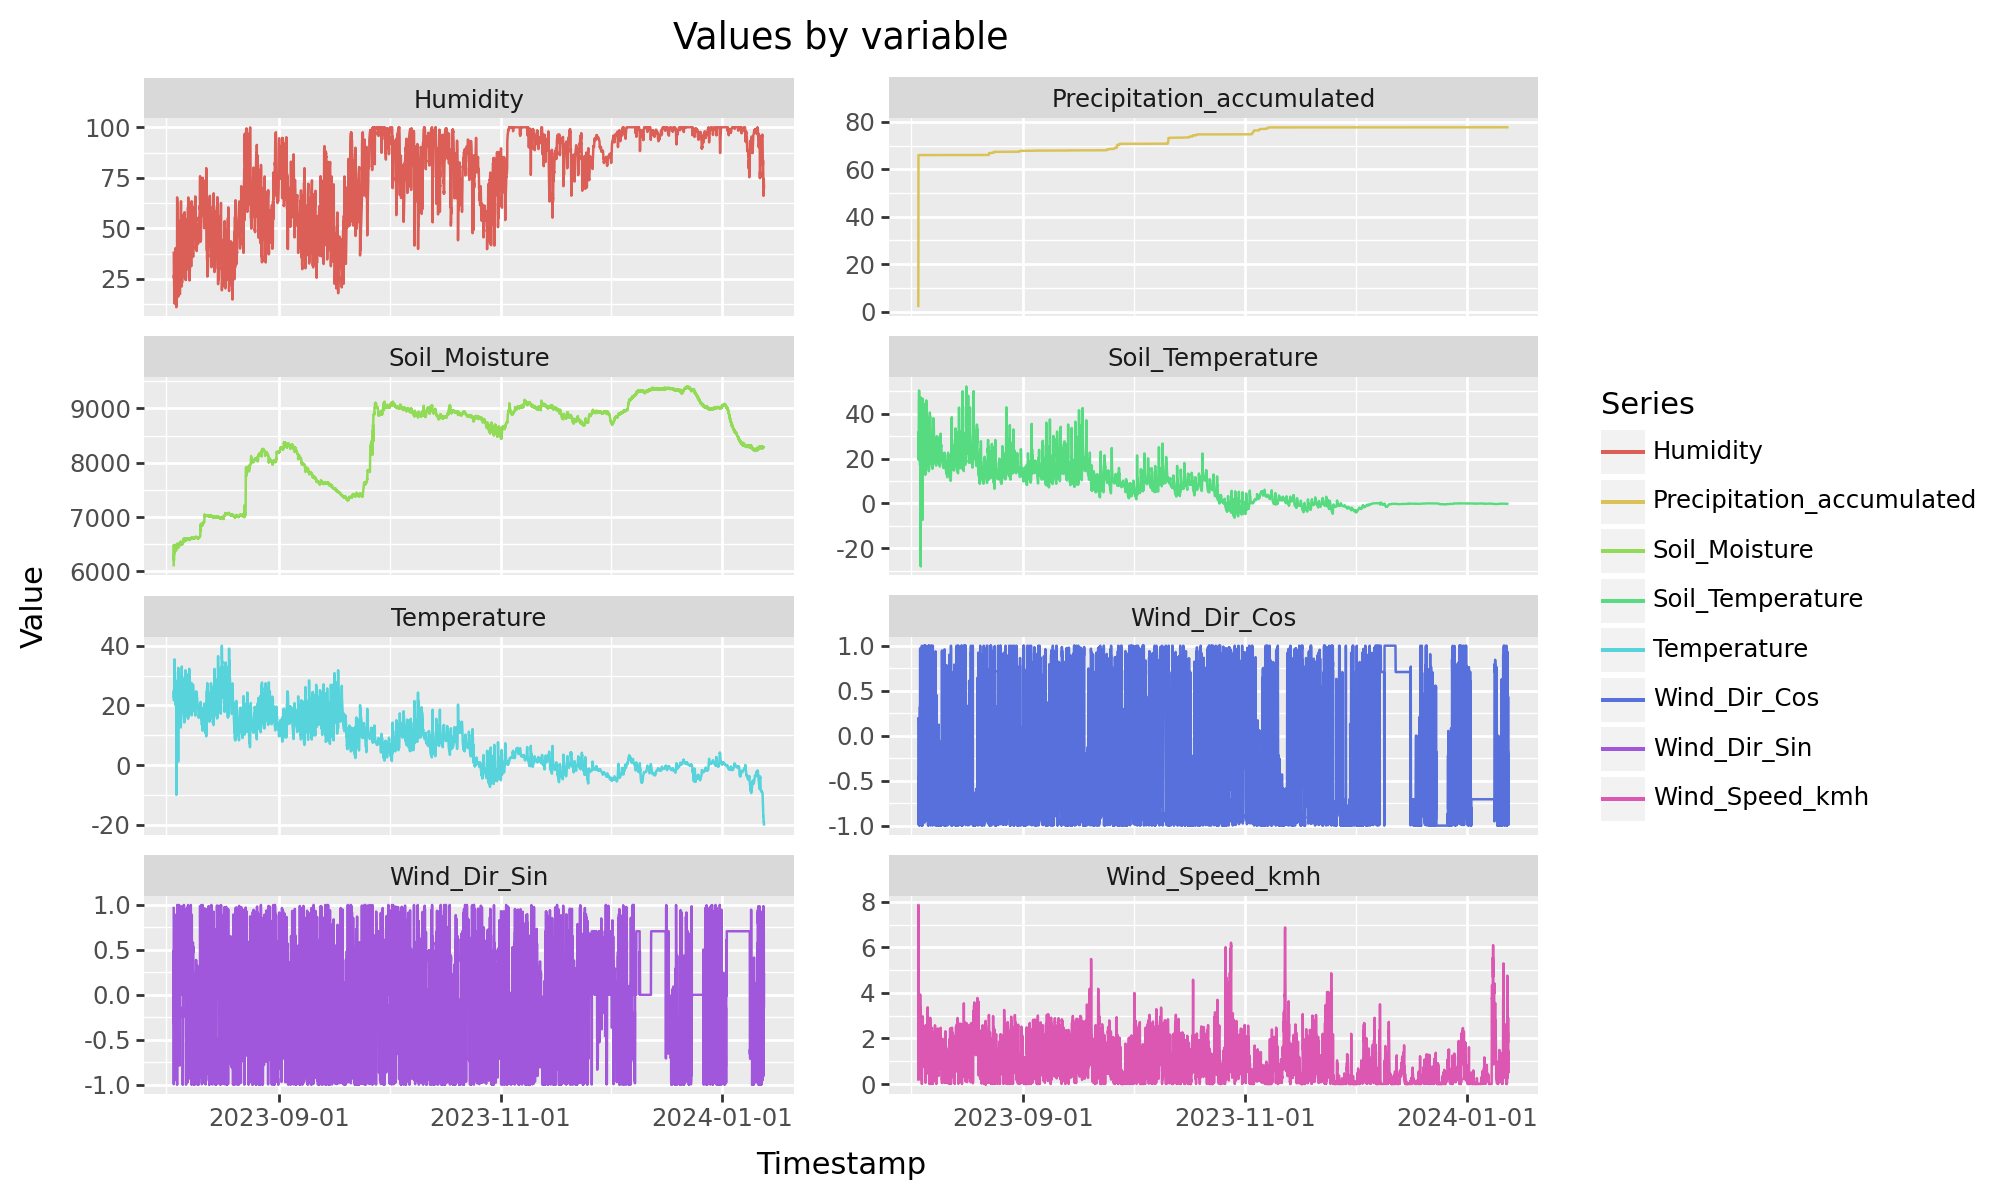

In [83]:
df_long = (
    df
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
)


plot = (
    ggplot(df_long, aes('Timestamp', 'value', color='variable'))
    + geom_line()
    + facet_wrap('~variable', scales='free_y', ncol=2)
    + labs(
        title='Values by variable',
        x='Timestamp',
        y='Value',
        color='Series'
    )
    + theme(figure_size=(10, 6))
)

plot.show()
